# **Final Project Analysis and Testing**

Since I designed and built the whole end-to-end pipeline and the Looker Studio Dashboards, this notebook is a combination of EDA used to decide on features I wanted to show in the historical and real-time dashboards and validating outputs from the pipeline/model/API. The first half is testing and validation for the pipeline and the second half is data analysis/visualization/conceptualization for the Looker Studio dashboard.

# **Retrieve Historical Data From the API (2022-2024 Specifically)**

Prompt: Create a script to authenticate with Google Cloud

In [1]:
!pip install -q google-cloud-bigquery google-cloud-storage google-cloud-pubsub requests

from google.colab import auth
print("Authenticating to Google Cloud...")
auth.authenticate_user()
print("Authentication successful.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 4.8 MB/s eta 0:00:00
Authenticating to Google Cloud...
Authentication successful.


Prompt: Create a script to pull historical forecast data from the Open-meteo API. I want to pull the forecast for NYC each day starting from 2022 through 2024. I want max/min temperatures for each day, precipitation, and wind speed data. Make sure the measurements are U.S. based so inches, Fahrenheit, etc. I want to save monthly CSVs and then make them into one combined final CSV.

In [ ]:
# =========================================
# Open-Meteo Historical DAILY Weather Pull
# (2022-01-01 to 2025-1-1, America/New_York)
# U.S. units: Fahrenheit, mph, inches
# Saves monthly CSVs + one combined CSV
# =========================================

!pip -q install pandas requests

import os
import time
import requests
import pandas as pd

# --------- CONFIG ----------
LAT = 40.7128
LON = -74.0060
TIMEZONE = "America/New_York"

START_DATE = "2022-01-01"
END_DATE   = "2025-1-1"  # inclusive

OUT_DIR = "open_meteo_daily_monthly"
COMBINED_CSV = "open_meteo_daily_2022_2024_us_units.csv"

DAILY_VARS = [
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "wind_speed_10m_max",
]

# U.S. units (per Open-Meteo docs)
TEMP_UNIT = "fahrenheit"
WIND_UNIT = "mph"
PRECIP_UNIT = "inch"

MAX_RETRIES = 5
SLEEP_BETWEEN_CALLS_SEC = 0.2
# ----------------------------------------


def month_range(start_yyyy_mm_dd: str, end_yyyy_mm_dd: str):
    s = pd.to_datetime(start_yyyy_mm_dd).date().replace(day=1)
    e = pd.to_datetime(end_yyyy_mm_dd).date()
    cur = s
    while cur <= e:
        next_month = (pd.Timestamp(cur) + pd.offsets.MonthBegin(1)).date()
        end_month = next_month - pd.Timedelta(days=1)
        start_clamped = max(cur, pd.to_datetime(start_yyyy_mm_dd).date())
        end_clamped = min(end_month, e)
        yield start_clamped.isoformat(), end_clamped.isoformat()
        cur = next_month


def fetch_open_meteo_daily(start_date: str, end_date: str) -> pd.DataFrame:
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": start_date,
        "end_date": end_date,
        "timezone": TIMEZONE,

        # U.S. units:
        "temperature_unit": TEMP_UNIT,
        "wind_speed_unit": WIND_UNIT,
        "precipitation_unit": PRECIP_UNIT,

        "daily": ",".join(DAILY_VARS),
    }

    last_err = None
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            r = requests.get(url, params=params, timeout=60)
            if r.status_code in (429, 500, 502, 503, 504):
                time.sleep(2 ** attempt)
                continue
            r.raise_for_status()

            js = r.json()
            daily = js["daily"]
            daily_units = js.get("daily_units", {})

            df = pd.DataFrame({"date": daily["time"]})
            for v in DAILY_VARS:
                df[v] = daily.get(v, [pd.NA] * len(df))

            # Metadata (useful later in BigQuery / documentation)
            df["timezone"] = TIMEZONE
            df["temperature_unit"] = TEMP_UNIT
            df["wind_speed_unit"] = WIND_UNIT
            df["precipitation_unit"] = PRECIP_UNIT

            # Optional: store units reported by API (same for all rows, but handy)
            df["unit_temperature_2m_max"] = daily_units.get("temperature_2m_max", "")
            df["unit_temperature_2m_min"] = daily_units.get("temperature_2m_min", "")
            df["unit_precipitation_sum"] = daily_units.get("precipitation_sum", "")
            df["unit_wind_speed_10m_max"] = daily_units.get("wind_speed_10m_max", "")

            df["date"] = pd.to_datetime(df["date"]).dt.date.astype(str)
            return df

        except Exception as e:
            last_err = e
            time.sleep(2 ** attempt)

    raise RuntimeError(f"Failed after {MAX_RETRIES} retries. Last error: {last_err}")


os.makedirs(OUT_DIR, exist_ok=True)

parts = []
for m_start, m_end in month_range(START_DATE, END_DATE):
    print(f"Fetching {m_start} -> {m_end} ...")
    df_m = fetch_open_meteo_daily(m_start, m_end)

    ym = pd.to_datetime(m_start).strftime("%Y-%m")
    out_path = os.path.join(OUT_DIR, f"open_meteo_daily_{ym}_us_units.csv")
    df_m.to_csv(out_path, index=False)

    parts.append(df_m)
    time.sleep(SLEEP_BETWEEN_CALLS_SEC)

df_all = (
    pd.concat(parts, ignore_index=True)
      .drop_duplicates(subset=["date"])
      .sort_values("date")
)
df_all.to_csv(COMBINED_CSV, index=False)

print("\nDone.")
print("Combined file:", COMBINED_CSV)
print("Rows:", len(df_all))
print(df_all.head())


Fetching 2022-01-01 -> 2022-01-31 ...
Fetching 2022-02-01 -> 2022-02-28 ...
Fetching 2022-03-01 -> 2022-03-31 ...
Fetching 2022-04-01 -> 2022-04-30 ...
Fetching 2022-05-01 -> 2022-05-31 ...
Fetching 2022-06-01 -> 2022-06-30 ...
Fetching 2022-07-01 -> 2022-07-31 ...
Fetching 2022-08-01 -> 2022-08-31 ...
Fetching 2022-09-01 -> 2022-09-30 ...
Fetching 2022-10-01 -> 2022-10-31 ...
Fetching 2022-11-01 -> 2022-11-30 ...
Fetching 2022-12-01 -> 2022-12-31 ...
Fetching 2023-01-01 -> 2023-01-31 ...
Fetching 2023-02-01 -> 2023-02-28 ...
Fetching 2023-03-01 -> 2023-03-31 ...
Fetching 2023-04-01 -> 2023-04-30 ...
Fetching 2023-05-01 -> 2023-05-31 ...
Fetching 2023-06-01 -> 2023-06-30 ...
Fetching 2023-07-01 -> 2023-07-31 ...
Fetching 2023-08-01 -> 2023-08-31 ...
Fetching 2023-09-01 -> 2023-09-30 ...
Fetching 2023-10-01 -> 2023-10-31 ...
Fetching 2023-11-01 -> 2023-11-30 ...
Fetching 2023-12-01 -> 2023-12-31 ...
Fetching 2024-01-01 -> 2024-01-31 ...
Fetching 2024-02-01 -> 2024-02-29 ...
Fetching 202

Prompt: I want to validate that our date range is correct and that time zones aren't making the start and end date weird, can you write a script to check?

In [ ]:
import pandas as pd

COMBINED_CSV = "open_meteo_daily_2022_2024_us_units.csv"  # or your filename

df_all = pd.read_csv(COMBINED_CSV)
df_all["date"] = pd.to_datetime(df_all["date"])

min_date = df_all["date"].min()
max_date = df_all["date"].max()
day_count = df_all["date"].nunique()

print("Min date:", min_date.date())
print("Max date:", max_date.date())
print("Distinct days:", day_count)


Min date: 2022-01-01
Max date: 2025-01-01
Distinct days: 1097


Prompt: It looks like our pull is going 1 day over the intended, can you make sure that the last day we have data for is 12/31/2024?

In [ ]:
# =========================================
# Open-Meteo Historical DAILY Weather Pull
# (2022-01-01 to 2024-12-31, America/New_York)
# U.S. units: Fahrenheit, mph, inches
# Saves monthly CSVs + one combined CSV
# =========================================

!pip -q install pandas requests

import os
import time
import requests
import pandas as pd

# --------- CONFIG ----------
LAT = 40.7128
LON = -74.0060
TIMEZONE = "America/New_York"

START_DATE = "2022-01-01"
END_DATE   = "2024-12-31"  # inclusive

OUT_DIR = "open_meteo_daily_monthly"
COMBINED_CSV = "open_meteo_daily_2022_2024_us_units.csv"

DAILY_VARS = [
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "wind_speed_10m_max",
]

# U.S. units (per Open-Meteo docs)
TEMP_UNIT = "fahrenheit"
WIND_UNIT = "mph"
PRECIP_UNIT = "inch"

MAX_RETRIES = 5
SLEEP_BETWEEN_CALLS_SEC = 0.2
# ----------------------------------------


def month_range(start_yyyy_mm_dd: str, end_yyyy_mm_dd: str):
    s = pd.to_datetime(start_yyyy_mm_dd).date().replace(day=1)
    e = pd.to_datetime(end_yyyy_mm_dd).date()
    cur = s
    while cur <= e:
        next_month = (pd.Timestamp(cur) + pd.offsets.MonthBegin(1)).date()
        end_month = next_month - pd.Timedelta(days=1)
        start_clamped = max(cur, pd.to_datetime(start_yyyy_mm_dd).date())
        end_clamped = min(end_month, e)
        yield start_clamped.isoformat(), end_clamped.isoformat()
        cur = next_month


def fetch_open_meteo_daily(start_date: str, end_date: str) -> pd.DataFrame:
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": start_date,
        "end_date": end_date,
        "timezone": TIMEZONE,

        # U.S. units:
        "temperature_unit": TEMP_UNIT,
        "wind_speed_unit": WIND_UNIT,
        "precipitation_unit": PRECIP_UNIT,

        "daily": ",".join(DAILY_VARS),
    }

    last_err = None
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            r = requests.get(url, params=params, timeout=60)
            if r.status_code in (429, 500, 502, 503, 504):
                time.sleep(2 ** attempt)
                continue
            r.raise_for_status()

            js = r.json()
            daily = js["daily"]
            daily_units = js.get("daily_units", {})

            df = pd.DataFrame({"date": daily["time"]})
            for v in DAILY_VARS:
                df[v] = daily.get(v, [pd.NA] * len(df))

            # Metadata (useful later in BigQuery / documentation)
            df["timezone"] = TIMEZONE
            df["temperature_unit"] = TEMP_UNIT
            df["wind_speed_unit"] = WIND_UNIT
            df["precipitation_unit"] = PRECIP_UNIT

            # Optional: store units reported by API (same for all rows, but handy)
            df["unit_temperature_2m_max"] = daily_units.get("temperature_2m_max", "")
            df["unit_temperature_2m_min"] = daily_units.get("temperature_2m_min", "")
            df["unit_precipitation_sum"] = daily_units.get("precipitation_sum", "")
            df["unit_wind_speed_10m_max"] = daily_units.get("wind_speed_10m_max", "")

            df["date"] = pd.to_datetime(df["date"]).dt.date.astype(str)
            return df

        except Exception as e:
            last_err = e
            time.sleep(2 ** attempt)

    raise RuntimeError(f"Failed after {MAX_RETRIES} retries. Last error: {last_err}")


os.makedirs(OUT_DIR, exist_ok=True)

parts = []
for m_start, m_end in month_range(START_DATE, END_DATE):
    print(f"Fetching {m_start} -> {m_end} ...")
    df_m = fetch_open_meteo_daily(m_start, m_end)

    ym = pd.to_datetime(m_start).strftime("%Y-%m")
    out_path = os.path.join(OUT_DIR, f"open_meteo_daily_{ym}_us_units.csv")
    df_m.to_csv(out_path, index=False)

    parts.append(df_m)
    time.sleep(SLEEP_BETWEEN_CALLS_SEC)

df_all = (
    pd.concat(parts, ignore_index=True)
      .drop_duplicates(subset=["date"])
      .sort_values("date")
)
df_all.to_csv(COMBINED_CSV, index=False)

print("\nDone.")
print("Combined file:", COMBINED_CSV)
print("Rows:", len(df_all))
print(df_all.head())


Fetching 2022-01-01 -> 2022-01-31 ...
Fetching 2022-02-01 -> 2022-02-28 ...
Fetching 2022-03-01 -> 2022-03-31 ...
Fetching 2022-04-01 -> 2022-04-30 ...
Fetching 2022-05-01 -> 2022-05-31 ...
Fetching 2022-06-01 -> 2022-06-30 ...
Fetching 2022-07-01 -> 2022-07-31 ...
Fetching 2022-08-01 -> 2022-08-31 ...
Fetching 2022-09-01 -> 2022-09-30 ...
Fetching 2022-10-01 -> 2022-10-31 ...
Fetching 2022-11-01 -> 2022-11-30 ...
Fetching 2022-12-01 -> 2022-12-31 ...
Fetching 2023-01-01 -> 2023-01-31 ...
Fetching 2023-02-01 -> 2023-02-28 ...
Fetching 2023-03-01 -> 2023-03-31 ...
Fetching 2023-04-01 -> 2023-04-30 ...
Fetching 2023-05-01 -> 2023-05-31 ...
Fetching 2023-06-01 -> 2023-06-30 ...
Fetching 2023-07-01 -> 2023-07-31 ...
Fetching 2023-08-01 -> 2023-08-31 ...
Fetching 2023-09-01 -> 2023-09-30 ...
Fetching 2023-10-01 -> 2023-10-31 ...
Fetching 2023-11-01 -> 2023-11-30 ...
Fetching 2023-12-01 -> 2023-12-31 ...
Fetching 2024-01-01 -> 2024-01-31 ...
Fetching 2024-02-01 -> 2024-02-29 ...
Fetching 202

Prompt: Let's check again to make sure this is right.

In [ ]:
import pandas as pd

COMBINED_CSV = "open_meteo_daily_2022_2024_us_units.csv"  # or your filename

df_all = pd.read_csv(COMBINED_CSV)
df_all["date"] = pd.to_datetime(df_all["date"])

min_date = df_all["date"].min()
max_date = df_all["date"].max()
day_count = df_all["date"].nunique()

print("Min date:", min_date.date())
print("Max date:", max_date.date())
print("Distinct days:", day_count)


Min date: 2022-01-01
Max date: 2024-12-31
Distinct days: 1096


Prompt: I need to push the local CSVs from this notebook to my bucket in my project. My project ID is mgmt467-final-project and the bucket/folder I want to push to is weather/raw/open_meteo_daily_monthly. Can you write me code to do this?

In [ ]:
!gsutil -m cp open_meteo_daily_monthly/*.csv \
  gs://mgmt467-final-project/weather/raw/open_meteo_daily_monthly/


Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-02_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-03_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-01_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-04_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-05_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-09_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-06_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-08_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_daily_2022-07_us_units.csv [Content-Type=text/csv]...
Copying file://open_meteo_daily_monthly/open_meteo_dail

Prompt: I want to double check our coordinates for the API data to make sure that we actually have NYC. Can you write me print statements for the latitude and longitude so I can manually double check?

In [ ]:
print("LAT =", LAT)
print("LON =", LON)


LAT = 40.7128
LON = -74.006


# **ML Model**

In [ ]:
!pip install -q google-cloud-bigquery google-cloud-storage google-cloud-pubsub requests

from google.colab import auth
print("Authenticating to Google Cloud...")
auth.authenticate_user()
print("Authentication successful.")


Authenticating to Google Cloud...
Authentication successful.


Prompt: I have two raw tables in BigQuery: One with all of the combined 2022-2024 forecast data and one with all of the combined CitiBike CSV data from their website for 2022-2024 also. I standardized the dates and created a curated table for each, then joined them on the date to have the trip and forecast data together. I want to use this table to train 2 regression models: 1 for predicting member trips and one for predicting casual trips. The table with the training data is called "bike_weather_daily." Write me a script to train the 2 models with a features table.

In [ ]:
# --- Configuration for Citibike + Weather Project ---

PROJECT_ID = "mgmt-467-project-1"
REGION = "us-central1"     # keep consistent with your other work

# Pub/Sub (for streaming / forecast later)
TOPIC_NAME = "citibike-weather-topic"        # you'll create this in GCP
SUBSCRIPTION_NAME = "citibike-weather-sub"   # subscriber for Dataflow

# BigQuery datasets (you already created these)
BQ_DATASET_RAW = "bike_raw"
BQ_DATASET_CURATED = "bike_curated"

# BigQuery tables (names we’ve been using)
BQ_TABLE_DAILY_JOINED      = "bike_weather_daily"          # historical join
BQ_TABLE_FEATURES          = "bike_weather_features"       # training features
BQ_TABLE_FORECAST_FEATURES = "bike_weather_forecast_feat"  # future 7-day features
BQ_TABLE_FORECAST_OUTPUT   = "bike_demand_forecast_7d"     # model predictions

# BQML model name
MODEL_NAME_MEMBER = "bike_demand_member_model"
MODEL_NAME_CASUAL = "bike_demand_casual_model"


# Set the project for gcloud commands (like before)
!gcloud config set project $PROJECT_ID


Updated property [core/project].


In [ ]:
from google.cloud import bigquery

bq_client = bigquery.Client(project=PROJECT_ID)
print("BigQuery client ready for project:", PROJECT_ID)


BigQuery client ready for project: mgmt-467-project-1


In [ ]:
features_query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET_CURATED}.{BQ_TABLE_FEATURES}` AS
SELECT
  date,
  trips,
  member_trips,
  casual_trips,
  temperature_2m_max,
  temperature_2m_min,
  precipitation_sum,
  wind_speed_10m_max,
  EXTRACT(DAYOFWEEK FROM date) AS dow,        -- 1=Sunday
  EXTRACT(MONTH FROM date)     AS month,
  EXTRACT(ISOWEEK FROM date)   AS iso_week,
  CASE WHEN EXTRACT(DAYOFWEEK FROM date) IN (1,7) THEN 1 ELSE 0 END AS is_weekend
FROM `{PROJECT_ID}.{BQ_DATASET_CURATED}.{BQ_TABLE_DAILY_JOINED}`
WHERE date BETWEEN '2022-01-01' AND '2024-12-31';
"""

job = bq_client.query(features_query)
job.result()  # wait for completion
print("Created features table:",
      f"{PROJECT_ID}.{BQ_DATASET_CURATED}.{BQ_TABLE_FEATURES}")


Created features table: mgmt-467-project-1.bike_curated.bike_weather_features


In [ ]:
preview_query = f"""
SELECT *
FROM `{PROJECT_ID}.{BQ_DATASET_CURATED}.{BQ_TABLE_FEATURES}`
ORDER BY date
LIMIT 5;
"""
features_preview = bq_client.query(preview_query).to_dataframe()
features_preview


,date,trips,member_trips,casual_trips,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,dow,month,iso_week,is_weekend
0,2022-01-01,16679,12001,4678,53.1,45.6,1.043,11.9,7,1,52,1
1,2022-01-02,43013,31034,11979,56.7,35.9,0.346,16.5,1,1,52,1
2,2022-01-03,32796,28493,4303,35.1,23.6,0.075,19.2,2,1,1,0
3,2022-01-04,36996,31772,5224,33.3,20.4,0.000,13.3,3,1,1,0
4,2022-01-05,34489,29511,4978,44.8,28.4,0.012,14.3,4,1,1,0


In [ ]:
# Member trip prediction
train_member_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_MEMBER}`
OPTIONS (
  model_type = 'linear_reg',
  input_label_cols = ['member_trips'],
  data_split_method = 'AUTO_SPLIT'
) AS
SELECT
  member_trips,
  temperature_2m_max,
  temperature_2m_min,
  precipitation_sum,
  wind_speed_10m_max,
  dow,
  month,
  is_weekend
FROM `{PROJECT_ID}.{BQ_DATASET_CURATED}.{BQ_TABLE_FEATURES}`;
"""

job = bq_client.query(train_member_query)
job.result()
print("Trained MEMBER model:", f"{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_MEMBER}")


# Casual trip prediction
train_casual_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_CASUAL}`
OPTIONS (
  model_type = 'linear_reg',
  input_label_cols = ['casual_trips'],
  data_split_method = 'AUTO_SPLIT'
) AS
SELECT
  casual_trips,
  temperature_2m_max,
  temperature_2m_min,
  precipitation_sum,
  wind_speed_10m_max,
  dow,
  month,
  is_weekend
FROM `{PROJECT_ID}.{BQ_DATASET_CURATED}.{BQ_TABLE_FEATURES}`;
"""

job = bq_client.query(train_casual_query)
job.result()
print("Trained CASUAL model:", f"{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_CASUAL}")



Trained MEMBER model: mgmt-467-project-1.bike_curated.bike_demand_member_model
Trained CASUAL model: mgmt-467-project-1.bike_curated.bike_demand_casual_model


Prompt: Can you also use ML.EVALUATE on each model to see the performance?

In [ ]:
# Member Evaluate
eval_member = f"""
SELECT * FROM ML.EVALUATE(
  MODEL `{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_MEMBER}`
);
"""
eval_member_df = bq_client.query(eval_member).to_dataframe()
eval_member_df


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,24261.605878,9.632855e+08,7.964697,20024.080109,0.268924,0.269017


In [ ]:
# Casual Evaluate
eval_casual = f"""
SELECT * FROM ML.EVALUATE(
  MODEL `{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_CASUAL}`
);
"""
eval_casual = bq_client.query(eval_casual).to_dataframe()
eval_casual


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,6328.57198,8.146434e+07,6.344649,4086.054834,0.496227,0.497276


# **Pub/Sub** Predictions Testing

Prompt: I just set up the Pub/Sub in GCP and I think everything should be set up to test real time predictions. I just put the first batch into the weather_forecast_stream table as a proof of concept, can you write a script to check if our prediction pipeline works?

In [ ]:
# --- Configuration ---

PROJECT_ID = "mgmt-467-project-1"      # you already had this
REGION     = "us-central1"

# BigQuery datasets
BQ_DATASET_CURATED = "bike_curated"
BQ_DATASET_RAW     = "bike_raw"

# Training / features table (the one you used to train the models)
BQ_TABLE_FEATURES = "bike_weather_daily"   # or "bike_weather_feat" if that's what you used

# Streaming forecast table written by Dataflow (what we just created)
BQ_TABLE_FORECAST_STREAM = "weather_forecast_stream"

# Model names (what we used earlier when training)
MODEL_NAME_MEMBER = "bike_demand_member_model"
MODEL_NAME_CASUAL = "bike_demand_casual_model"


In [ ]:
from google.cloud import bigquery
bq_client = bigquery.Client(project=PROJECT_ID)

check_forecast_sql = f"""
SELECT
  *
FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
ORDER BY ingest_timestamp DESC, forecast_date
LIMIT 20
"""

check_df = bq_client.query(check_forecast_sql).to_dataframe()
check_df


,forecast_date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,ingest_timestamp,source
0,2025-12-11,38.0,28.4,0.000,18.6,2025-12-11 06:25:09+00:00,open-meteo-forecast
1,2025-12-12,34.0,27.6,0.000,11.7,2025-12-11 06:25:09+00:00,open-meteo-forecast
2,2025-12-13,37.0,30.4,0.000,10.6,2025-12-11 06:25:09+00:00,open-meteo-forecast
3,2025-12-14,33.9,25.7,0.094,15.8,2025-12-11 06:25:09+00:00,open-meteo-forecast
4,2025-12-15,30.2,23.4,0.000,16.6,2025-12-11 06:25:09+00:00,open-meteo-forecast
5,2025-12-16,33.6,26.8,0.000,14.7,2025-12-11 06:25:09+00:00,open-meteo-forecast
6,2025-12-17,38.9,31.2,0.000,11.5,2025-12-11 06:25:09+00:00,open-meteo-forecast


In [ ]:
stream_features_sql = f"""
WITH latest_batch AS (
  -- Use only the newest forecast ingest from Pub/Sub/Dataflow
  SELECT *
  FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
  WHERE ingest_timestamp = (
    SELECT MAX(ingest_timestamp)
    FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
  )
),

features AS (
  SELECT
    forecast_date AS date,
    EXTRACT(DAYOFWEEK FROM forecast_date) AS dow,
    EXTRACT(MONTH     FROM forecast_date) AS month,
    IF(EXTRACT(DAYOFWEEK FROM forecast_date) IN (1,7), 1, 0) AS is_weekend,
    temperature_2m_min,
    temperature_2m_max,
    precipitation_sum,
    wind_speed_10m_max
  FROM latest_batch
)

SELECT * FROM features
ORDER BY date;
"""

features_df = bq_client.query(stream_features_sql).to_dataframe()
features_df


,date,dow,month,is_weekend,temperature_2m_min,temperature_2m_max,precipitation_sum,wind_speed_10m_max
0,2025-12-11,5,12,0,28.4,38.0,0.000,18.6
1,2025-12-12,6,12,0,27.6,34.0,0.000,11.7
2,2025-12-13,7,12,1,30.4,37.0,0.000,10.6
3,2025-12-14,1,12,1,25.7,33.9,0.094,15.8
4,2025-12-15,2,12,0,23.4,30.2,0.000,16.6
5,2025-12-16,3,12,0,26.8,33.6,0.000,14.7
6,2025-12-17,4,12,0,31.2,38.9,0.000,11.5


In [ ]:
predict_sql = f"""
WITH latest_batch AS (
  SELECT *
  FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
  WHERE ingest_timestamp = (
    SELECT MAX(ingest_timestamp)
    FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
  )
),

features AS (
  SELECT
    forecast_date AS date,
    EXTRACT(DAYOFWEEK FROM forecast_date) AS dow,
    EXTRACT(MONTH     FROM forecast_date) AS month,
    IF(EXTRACT(DAYOFWEEK FROM forecast_date) IN (1,7), 1, 0) AS is_weekend,
    temperature_2m_min,
    temperature_2m_max,
    precipitation_sum,
    wind_speed_10m_max
  FROM latest_batch
),

member_pred AS (
  SELECT
    date,
    predicted_member_trips
  FROM ML.PREDICT(
    MODEL `{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_MEMBER}`,
    (SELECT * FROM features)
  )
),

casual_pred AS (
  SELECT
    date,
    predicted_casual_trips
  FROM ML.PREDICT(
    MODEL `{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_CASUAL}`,
    (SELECT * FROM features)
  )
)

SELECT
  f.date,
  member_pred.predicted_member_trips,
  casual_pred.predicted_casual_trips,
  member_pred.predicted_member_trips
    + casual_pred.predicted_casual_trips AS predicted_total_trips,
  f.temperature_2m_min,
  f.temperature_2m_max,
  f.precipitation_sum,
  f.wind_speed_10m_max
FROM features f
JOIN member_pred USING (date)
JOIN casual_pred USING (date)
ORDER BY f.date;
"""

forecast_df = bq_client.query(predict_sql).to_dataframe()
forecast_df


,date,predicted_member_trips,predicted_casual_trips,predicted_total_trips,temperature_2m_min,temperature_2m_max,precipitation_sum,wind_speed_10m_max
0,2025-12-11,62949.376079,6802.661796,69752.037875,28.4,38.0,0.000,18.6
1,2025-12-12,64320.386633,6607.277484,70927.664118,27.6,34.0,0.000,11.7
2,2025-12-13,51517.000319,16230.083788,67747.084106,30.4,37.0,0.000,10.6
3,2025-12-14,35423.911457,8400.194887,43824.106344,25.7,33.9,0.094,15.8
4,2025-12-15,51333.127834,656.066903,51989.194736,23.4,30.2,0.000,16.6
5,2025-12-16,57671.745026,3487.578686,61159.323713,26.8,33.6,0.000,14.7
6,2025-12-17,67359.072368,7564.715939,74923.788307,31.2,38.9,0.000,11.5


Prompt: Awesome, it seems like it's at least initially working. Can you run EXPLAIN_PREDICT on our models?

In [ ]:
explain_member_sql = f"""
WITH latest_batch AS (
  SELECT *
  FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
  WHERE ingest_timestamp = (
    SELECT MAX(ingest_timestamp)
    FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
  )
),

features AS (
  SELECT
    forecast_date AS date,
    EXTRACT(DAYOFWEEK FROM forecast_date) AS dow,
    EXTRACT(MONTH     FROM forecast_date) AS month,
    IF(EXTRACT(DAYOFWEEK FROM forecast_date) IN (1,7), 1, 0) AS is_weekend,
    temperature_2m_min,
    temperature_2m_max,
    precipitation_sum,
    wind_speed_10m_max
  FROM latest_batch
)

SELECT * FROM ML.EXPLAIN_PREDICT(
  MODEL `{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_MEMBER}`,
  (SELECT * FROM features)
) ORDER BY date;
"""

explain_member_df = bq_client.query(explain_member_sql).to_dataframe()
print("Member Trip Explanation:")
display(explain_member_df)

explain_casual_sql = f"""
WITH latest_batch AS (
  SELECT *
  FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
  WHERE ingest_timestamp = (
    SELECT MAX(ingest_timestamp)
    FROM `{PROJECT_ID}.{BQ_DATASET_RAW}.{BQ_TABLE_FORECAST_STREAM}`
  )
),

features AS (
  SELECT
    forecast_date AS date,
    EXTRACT(DAYOFWEEK FROM forecast_date) AS dow,
    EXTRACT(MONTH     FROM forecast_date) AS month,
    IF(EXTRACT(DAYOFWEEK FROM forecast_date) IN (1,7), 1, 0) AS is_weekend,
    temperature_2m_min,
    temperature_2m_max,
    precipitation_sum,
    wind_speed_10m_max
  FROM latest_batch
)

SELECT * FROM ML.EXPLAIN_PREDICT(
  MODEL `{PROJECT_ID}.{BQ_DATASET_CURATED}.{MODEL_NAME_CASUAL}`,
  (SELECT * FROM features)
) ORDER BY date;
"""

explain_casual_df = bq_client.query(explain_casual_sql).to_dataframe()
print("\nCasual Trip Explanation:")
display(explain_casual_df)

Member Trip Explanation:


,predicted_member_trips,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,date,dow,month,is_weekend,temperature_2m_min,temperature_2m_max,precipitation_sum,wind_speed_10m_max
0,54565.560674,"[{'feature': 'temperature_2m_max', 'attributio...",79152.699085,54565.560674,0.0,2025-12-13,7,12,1,27.3,38.4,0.000,10.9
1,34652.376714,"[{'feature': 'temperature_2m_max', 'attributio...",79152.699085,34652.376714,0.0,2025-12-14,1,12,1,17.0,32.9,0.370,14.3
2,52255.270840,"[{'feature': 'temperature_2m_max', 'attributio...",79152.699085,52255.270840,0.0,2025-12-15,2,12,0,18.0,29.3,0.000,16.6
3,57940.845529,"[{'feature': 'temperature_2m_max', 'attributio...",79152.699085,57940.845529,0.0,2025-12-16,3,12,0,24.6,32.5,0.000,13.5
4,63582.677874,"[{'feature': 'temperature_2m_max', 'attributio...",79152.699085,63582.677874,0.0,2025-12-17,4,12,0,31.0,37.7,0.000,14.2
5,75074.570024,"[{'feature': 'temperature_2m_max', 'attributio...",79152.699085,75074.570024,0.0,2025-12-18,5,12,0,35.8,43.6,0.000,9.6
6,74475.283038,"[{'feature': 'temperature_2m_max', 'attributio...",79152.699085,74475.283038,0.0,2025-12-19,6,12,0,34.4,48.4,0.012,21.3



Casual Trip Explanation:


,predicted_casual_trips,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,date,dow,month,is_weekend,temperature_2m_min,temperature_2m_max,precipitation_sum,wind_speed_10m_max
0,17224.351897,"[{'feature': 'temperature_2m_max', 'attributio...",19800.886133,17224.351897,0.0,2025-12-13,7,12,1,27.3,38.4,0.000,10.9
1,6852.141248,"[{'feature': 'temperature_2m_max', 'attributio...",19800.886133,6852.141248,0.0,2025-12-14,1,12,1,17.0,32.9,0.370,14.3
2,563.323529,"[{'feature': 'temperature_2m_max', 'attributio...",19800.886133,563.323529,0.0,2025-12-15,2,12,0,18.0,29.3,0.000,16.6
3,3243.175063,"[{'feature': 'temperature_2m_max', 'attributio...",19800.886133,3243.175063,0.0,2025-12-16,3,12,0,24.6,32.5,0.000,13.5
4,6407.910254,"[{'feature': 'temperature_2m_max', 'attributio...",19800.886133,6407.910254,0.0,2025-12-17,4,12,0,31.0,37.7,0.000,14.2
5,11048.822173,"[{'feature': 'temperature_2m_max', 'attributio...",19800.886133,11048.822173,0.0,2025-12-18,5,12,0,35.8,43.6,0.000,9.6
6,12544.834220,"[{'feature': 'temperature_2m_max', 'attributio...",19800.886133,12544.834220,0.0,2025-12-19,6,12,0,34.4,48.4,0.012,21.3


# **EDA and Dashboard Idea Conceptualization**

## Historical Dashboard EDA

Prompt: Can you create a couple scripts for me to create plotly figures in our colab notebook? I want to first focus on our historical data. Using bike_weather_features as our table, I want a plotly time series graph of daily total trips from 2022 to 2024, one of daily average temperature from 2022-2024, and one bar graph of total trips by day of the week from 2022-2024

In [2]:
!pip -q install plotly google-cloud-bigquery

from google.cloud import bigquery
import pandas as pd
import plotly.express as px

PROJECT_ID = "mgmt-467-project-1"  # change if needed
client = bigquery.Client(project=PROJECT_ID)

query = """
SELECT
  date,
  trips,
  temperature_2m_max,
  temperature_2m_min
FROM `mgmt-467-project-1.bike_curated.bike_weather_features`
WHERE date BETWEEN '2022-01-01' AND '2024-12-31'
ORDER BY date
"""

df = client.query(query).to_dataframe()

# Average temperature (simple max/min average)
df["avg_temp_f"] = (df["temperature_2m_max"] + df["temperature_2m_min"]) / 2.0

df.head()


,date,trips,temperature_2m_max,temperature_2m_min,avg_temp_f
0,2022-01-01,16679,53.1,45.6,49.35
1,2022-01-02,43013,56.7,35.9,46.30
2,2022-01-03,32796,35.1,23.6,29.35
3,2022-01-04,36996,33.3,20.4,26.85
4,2022-01-05,34489,44.8,28.4,36.60


In [3]:
fig_trips = px.line(
    df,
    x="date",
    y="trips",
    title="Daily Total CitiBike Trips (2022–2024)",
    labels={"date": "Date", "trips": "Total Trips"},
)

fig_trips.update_layout(template="plotly_white")
fig_trips.show()


In [4]:
fig_temp = px.line(
    df,
    x="date",
    y="avg_temp_f",
    title="Daily Average Temperature (°F, 2022–2024)",
    labels={"date": "Date", "avg_temp_f": "Average Temperature (°F)"},
)

fig_temp.update_layout(template="plotly_white")
fig_temp.show()


In [5]:
# Add day-of-week name
df["dow_name"] = df["date"].dt.day_name()

trips_by_dow = (
    df.groupby("dow_name", as_index=False)["trips"].sum()
)

# Order Monday–Sunday
dow_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]
trips_by_dow["dow_name"] = pd.Categorical(trips_by_dow["dow_name"],
                                          categories=dow_order,
                                          ordered=True)
trips_by_dow = trips_by_dow.sort_values("dow_name")

fig_dow = px.bar(
    trips_by_dow,
    x="dow_name",
    y="trips",
    title="Total Trips by Day of Week (2022–2024)",
    labels={"dow_name": "Day of Week", "trips": "Total Trips"},
)

fig_dow.update_layout(template="plotly_white")
fig_dow.show()


AttributeError: Can only use .dt accessor with datetimelike values

Prompt: "date" must be a string instead of a datetime in this table. Can you fix the script?

In [6]:
# Make sure date column is datetime
df["date"] = pd.to_datetime(df["date"])

# Add day-of-week name
df["dow_name"] = df["date"].dt.day_name()

trips_by_dow = (
    df.groupby("dow_name", as_index=False)["trips"].sum()
)

# Order Monday–Sunday
dow_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]
trips_by_dow["dow_name"] = pd.Categorical(
    trips_by_dow["dow_name"],
    categories=dow_order,
    ordered=True
)
trips_by_dow = trips_by_dow.sort_values("dow_name")

fig_dow = px.bar(
    trips_by_dow,
    x="dow_name",
    y="trips",
    title="Total Trips by Day of Week (2022–2024)",
    labels={"dow_name": "Day of Week", "trips": "Total Trips"},
)

fig_dow.update_layout(template="plotly_white")
fig_dow.show()


## Real-Time Analytics

Prompt: Since we've validated that our pipeline works and we have some real outputs in our trips_forecast table, I want to create some plotly charts for inspiration for our real time dashboard. Give me 2 plotly time series bar charts where one shows predicted casual trips over the 7 days and the other shows member trips over the 7 days. I also want another script to display the total number of predicted casual trips, members trips, and total trips over the next 7 days

In [7]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

PROJECT_ID = "mgmt-467-project-1"
TABLE_ID = "mgmt-467-project-1.bike_curated.trips_forecast"

bq_client = bigquery.Client(project=PROJECT_ID)

forecast_sql = f"""
SELECT
  forecast_date,
  predicted_casual_trips,
  predicted_member_trips,
  predicted_total_trips
FROM `{TABLE_ID}`
ORDER BY forecast_date
LIMIT 7
"""

df_forecast = bq_client.query(forecast_sql).to_dataframe()

# Make sure date is datetime for Plotly
df_forecast["forecast_date"] = pd.to_datetime(df_forecast["forecast_date"])

df_forecast


,forecast_date,predicted_casual_trips,predicted_member_trips,predicted_total_trips
0,2025-12-13,17083.424634,54298.333990,71381.758623
1,2025-12-14,6852.141248,34652.376714,41504.517962
2,2025-12-15,563.323529,52255.270840,52818.594369
3,2025-12-16,3243.175063,57940.845529,61184.020592
4,2025-12-17,6407.910254,63582.677874,69990.588128
5,2025-12-18,11048.822173,75074.570024,86123.392197
6,2025-12-19,12544.834220,74475.283038,87020.117257


In [8]:
# --- Casual trips bar chart ---
fig_casual = px.bar(
    df_forecast,
    x="forecast_date",
    y="predicted_casual_trips",
    title="Predicted Casual Trips – Next 7 Days",
    labels={
        "forecast_date": "Forecast Date",
        "predicted_casual_trips": "Predicted Casual Trips"
    }
)

fig_casual.update_layout(
    template="plotly_white",
    xaxis=dict(tickformat="%Y-%m-%d")
)

fig_casual.show()


# --- Member trips bar chart ---
fig_member = px.bar(
    df_forecast,
    x="forecast_date",
    y="predicted_member_trips",
    title="Predicted Member Trips – Next 7 Days",
    labels={
        "forecast_date": "Forecast Date",
        "predicted_member_trips": "Predicted Member Trips"
    }
)

fig_member.update_layout(
    template="plotly_white",
    xaxis=dict(tickformat="%Y-%m-%d")
)

fig_member.show()


In [9]:
# Ensure numeric types (just in case BigQuery returned decimals/objects)
for col in ["predicted_casual_trips", "predicted_member_trips", "predicted_total_trips"]:
    df_forecast[col] = pd.to_numeric(df_forecast[col])

total_casual = df_forecast["predicted_casual_trips"].sum()
total_member = df_forecast["predicted_member_trips"].sum()
total_trips  = df_forecast["predicted_total_trips"].sum()

print("Predicted Trips Over Next 7 Days")
print("---------------------------------")
print(f"Casual trips : {total_casual:,.0f}")
print(f"Member trips : {total_member:,.0f}")
print(f"Total trips  : {total_trips:,.0f}")


Predicted Trips Over Next 7 Days
---------------------------------
Casual trips : 57,744
Member trips : 412,279
Total trips  : 470,023


# **Dashboard Sections that Historical EDA Influenced**

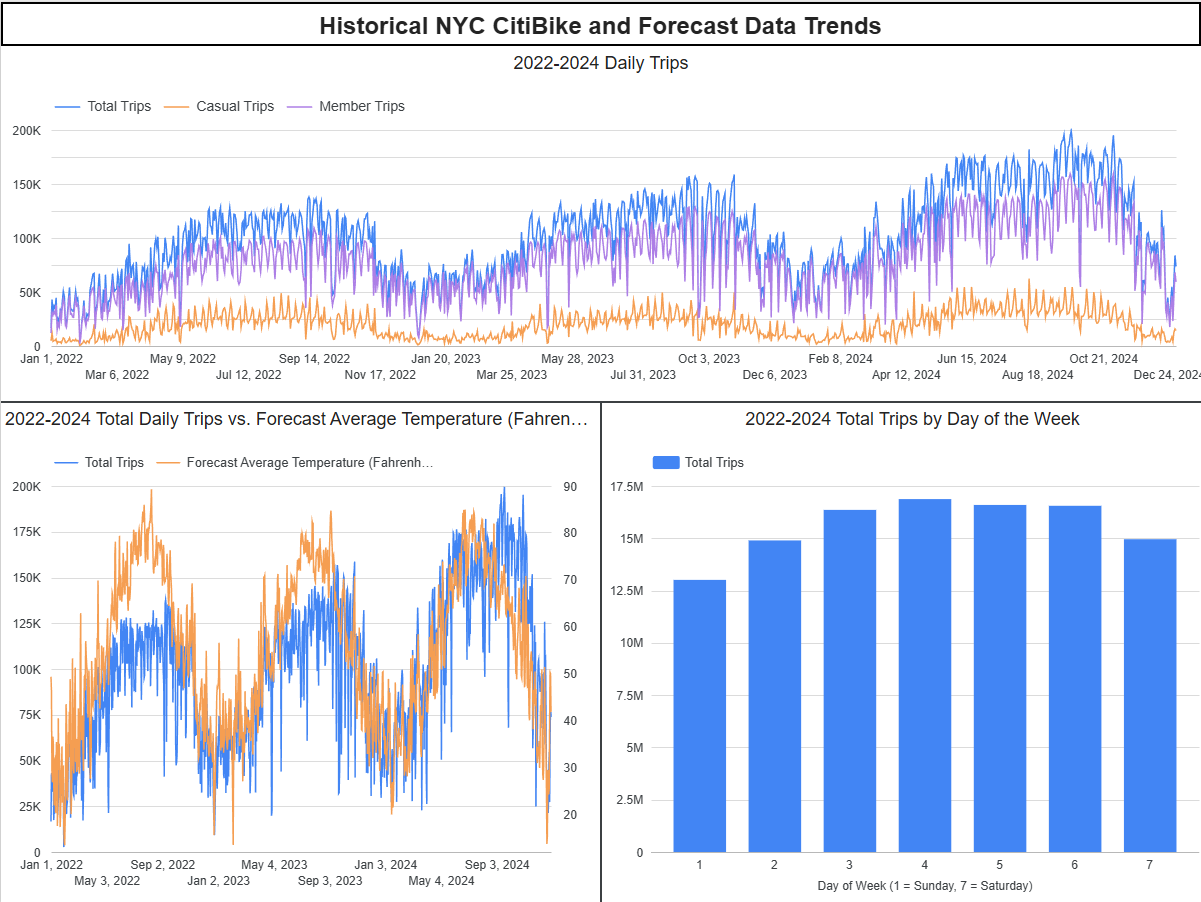

# **Dashboard Sections that Real Time EDA Influenced**

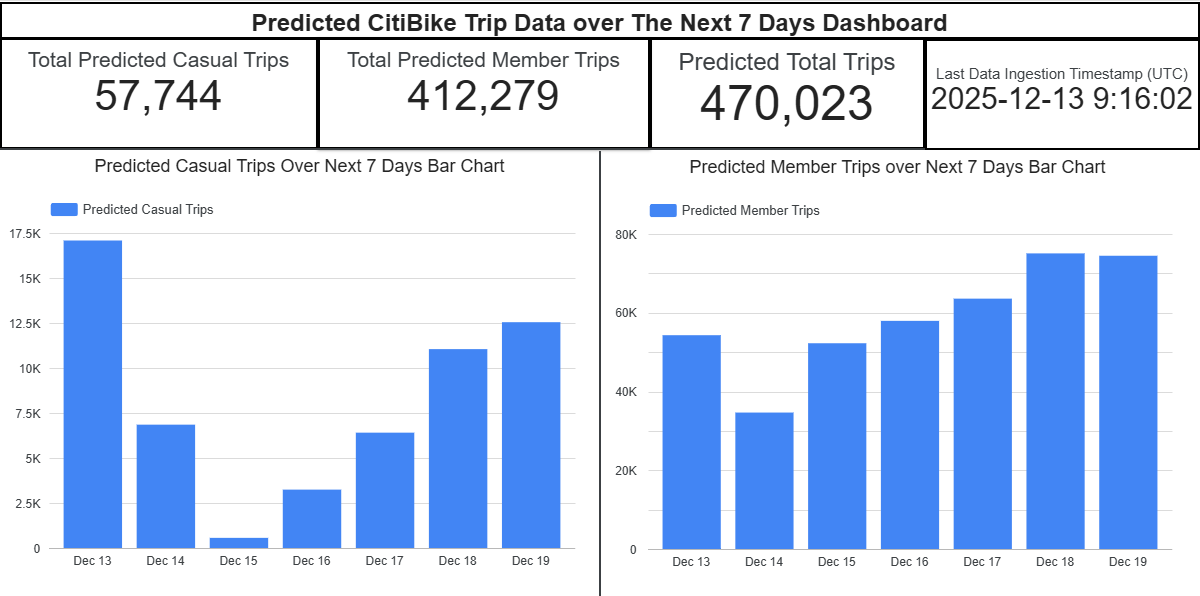